We use preprocessing functions and utilities from the earlier work done here: https://github.com/sydney-machine-learning/COVID19_sentinentanalysis

## **EDA**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import demoji
import re
import unicodedata
import nltk
import csv
import string
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import transformers
import warnings
import operator
import spacy

In [2]:
from wordcloud import WordCloud
from textblob import TextBlob
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from torch.utils.data import TensorDataset, DataLoader, Dataset, RandomSampler, SequentialSampler
from torchtext import data
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.metrics import hamming_loss, jaccard_score, label_ranking_average_precision_score, f1_score
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn import metrics

/home/slava/obsidian/.venv/lib/python3.12/site-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/tmp/ipykernel_21336/2798579249.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [3]:
%matplotlib inline
pd.options.display.max_colwidth = 250
SEED = 1024
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
warnings.filterwarnings('ignore')

In [4]:
nltk.download('all')
demoji.download_codes()

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /home/slava/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /home/slava/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /home/slava/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /home/slava/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_eng is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /home/slava/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]   

In [5]:
!git clone https://github.com/sydney-machine-learning/COVID19_sentinentanalysissocialmedia

fatal: destination path 'COVID19_sentinentanalysissocialmedia' already exists and is not an empty directory.


In [6]:
senwave = pd.read_csv("labeledEn.csv")
len(senwave)

10000

In [7]:
senwave.head()

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,1.245140e+18,A glass of wine keeps the corona away- DRAKE. No se diga ms cheers to that,1,0,0,0,0,0,0,0,0,1
1,1.245140e+18,Can Anyone tell me if you took the flu shot last year will it give you a positive result for Coronavirus even if you dont have it???,0,0,0,0,1,0,0,0,0,0
2,1.245140e+18,Btw producers send me beats Im working on music and smoke loud as we speak to get thru coronavirus pandemic,1,0,0,0,0,0,0,0,0,1
3,1.245140e+18,When someone you know.. apart of your family dies from the Coronavirus its shocking unexplainable. My whole day has been down.,0,0,0,0,0,1,0,0,0,0
4,1.245140e+18,"Dear soccer, I really miss you ,please come back already :( Also dear corona , Frick u for ruining everything",0,0,0,0,0,1,1,0,0,0


[2373, 498, 389, 1325, 1695, 2133, 3492, 631, 1207, 4476]


Text(0.5, 0, 'Count')

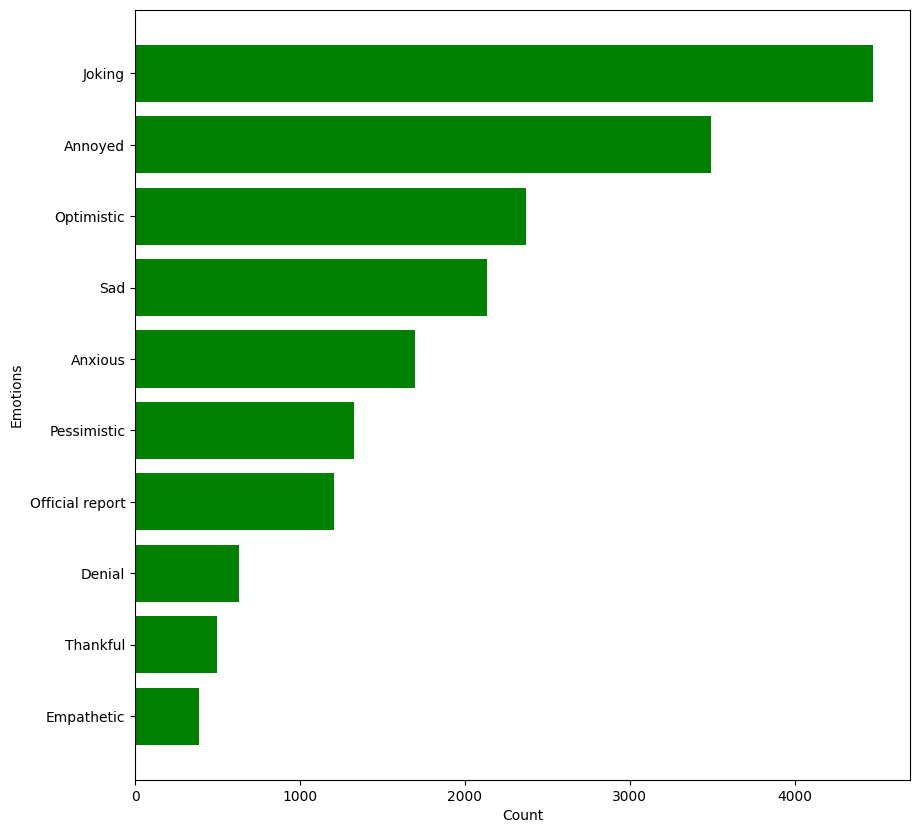

In [8]:
emotions = list(senwave.columns[2:])
scores = [sum(senwave[x]) for x in emotions]
print(scores)
pairs = []
for i in range(len(emotions)):
    pairs.append((emotions[i], scores[i]))
pairs = sorted(pairs, key=lambda x : x[1], reverse=False)
emotions_sorted = []
scores_sorted = []

for pair in pairs:
    emotions_sorted.append(pair[0])
    scores_sorted.append(pair[1])

fig = plt.figure(figsize = (10, 10))
plt.barh(emotions_sorted, scores_sorted, color = 'green')
plt.ylabel("Emotions")
plt.xlabel("Count")

In [9]:
rand_idx = np.random.randint(0, len(senwave))
print("Tweet : ", senwave.iloc[rand_idx]['Tweet'])
for e in emotions:
    print(e, ": ", senwave.iloc[rand_idx][e])

Tweet :  Wonder which asshole YouTuber is gonna make an April Fools joke about the coronavirus first? COVID19
Optimistic :  0
Thankful :  0
Empathetic :  0
Pessimistic :  0
Anxious :  0
Sad :  0
Annoyed :  0
Denial :  0
Official report :  0
Joking :  1


In [10]:
only_emotes = senwave[emotions]
only_emotes.head()

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,1,1,0,0,0


In [11]:
emote_array = np.zeros((10, 10))
e2i = {
    'Optimistic': 0,
    'Thankful': 1, 
    'Empathetic': 2, 
    'Pessimistic': 3, 
    'Anxious': 4, 
    'Sad': 5, 
    'Annoyed': 6, 
    'Denial': 7, 
    'Official report': 8,
    'Joking' : 9
}
for i in range(len(only_emotes)):
    l = only_emotes.iloc[i].tolist()
    for j in range(10):
        if l[j] == 1:
            emote_array[j][j] += 1
        for k in range(j+1, 10):                 # to avoid double counting.
            if (l[j] == 1) and (l[k] == 1):
                emote_array[j][k] += int(1)
                emote_array[k][j] += int(1)

In [12]:
emote_df = pd.DataFrame(emote_array, columns=emotions)
for col in emote_df:
    emote_df[col] = emote_df[col].astype(int)
emote_df

,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking
0,2373,235,171,226,246,291,379,72,156,982
1,235,498,28,15,41,29,67,14,70,92
2,171,28,389,18,50,71,41,7,7,63
3,226,15,18,1325,268,272,420,90,62,554
4,246,41,50,268,1695,360,452,95,138,510
5,291,29,71,272,360,2133,723,54,186,747
6,379,67,41,420,452,723,3492,261,122,1235
7,72,14,7,90,95,54,261,631,51,184
8,156,70,7,62,138,186,122,51,1207,95
9,982,92,63,554,510,747,1235,184,95,4476


<Axes: >

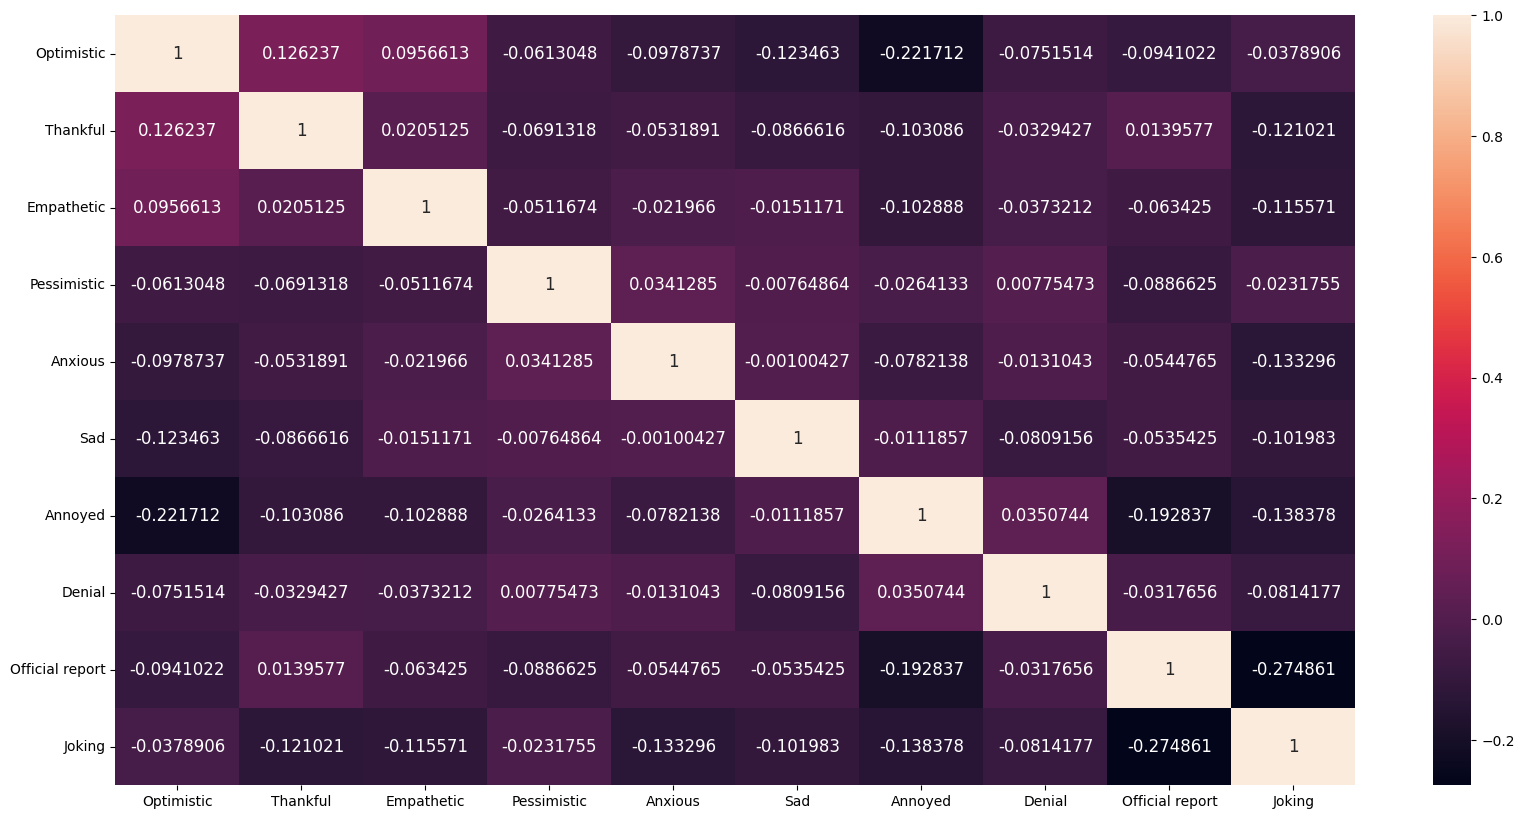

In [13]:
fig = plt.figure(figsize = (20, 10))
sns.heatmap(
    only_emotes.corr(),
    annot=True,
    xticklabels=emote_df.columns,
    yticklabels=emote_df.columns,
    fmt='g',
    annot_kws={"size" : 12}
)

In [14]:
senwave['n_emotions'] = \
    senwave['Optimistic'] + \
    senwave['Thankful'] + \
    senwave['Empathetic'] + \
    senwave['Pessimistic'] + \
    senwave['Anxious'] + \
    senwave['Sad'] + \
    senwave['Annoyed'] + \
    senwave['Official report'] + \
    senwave['Joking']

rowSums = senwave['n_emotions']
multiLabel_counts = rowSums.value_counts()

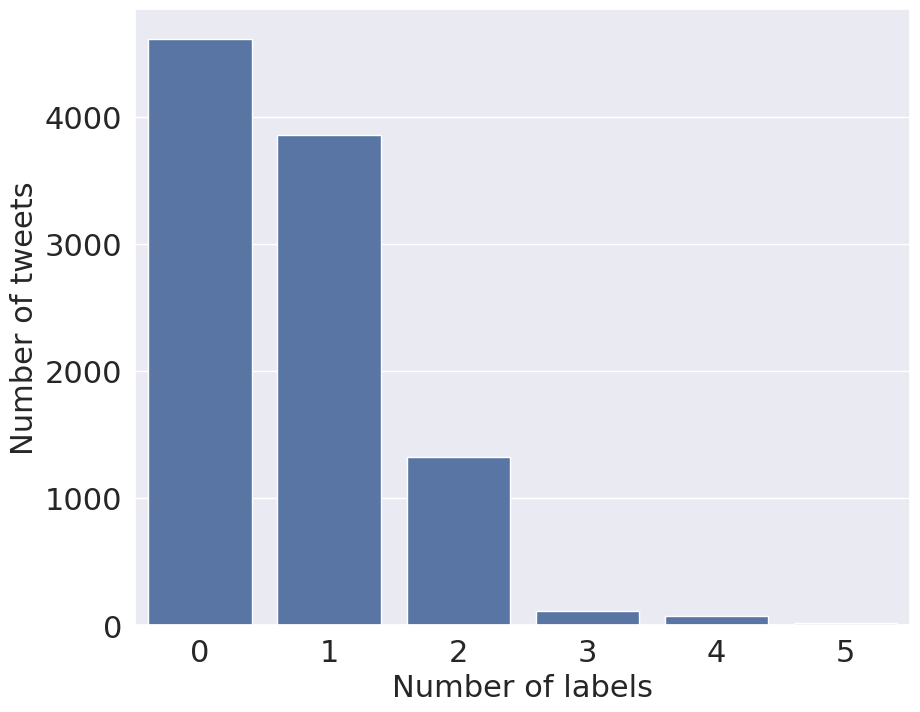

In [15]:
sns.set(font_scale = 2)
plt.figure(figsize = (10, 8))
ax = sns.barplot(multiLabel_counts.values, orient='v')
# ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values, orient = 'v')
#plt.title("Tweets having multiple labels")
plt.ylabel('Number of tweets', fontsize = 22)
plt.xlabel('Number of labels', fontsize = 22)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    #ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [16]:
multiLabel_counts

n_emotions
2    4617
1    3856
3    1323
4     111
0      76
5      17
Name: count, dtype: int64

<Axes: >

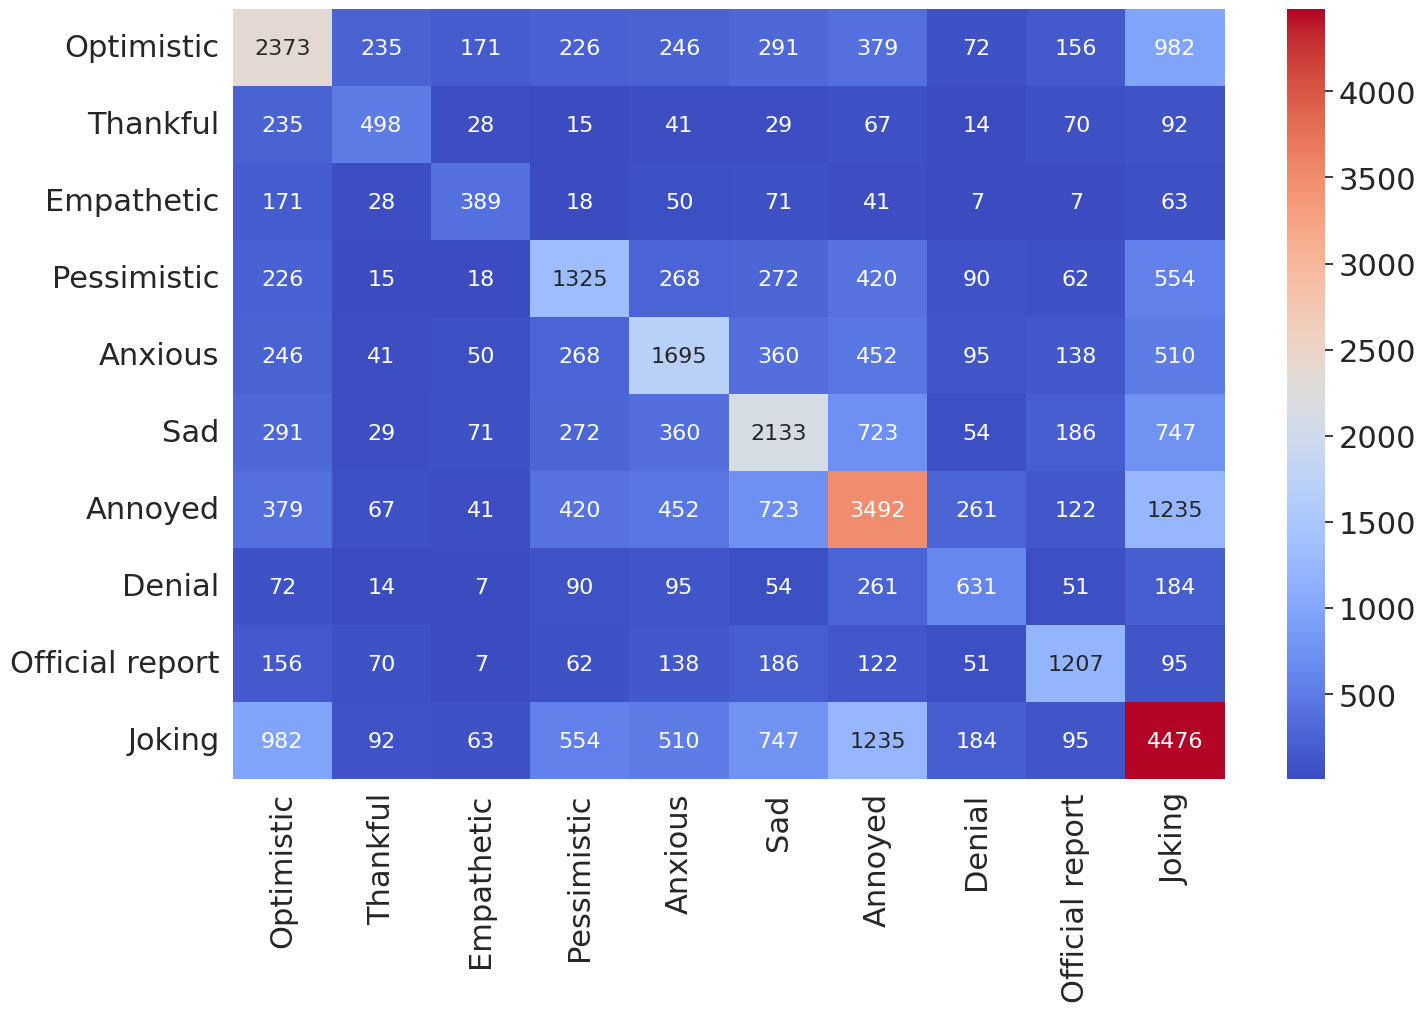

In [17]:
fig = plt.figure(figsize=(16,10))
sns.set(font_scale = 2)
sns.heatmap(emote_df, annot = True, cmap = 'coolwarm', xticklabels = emote_df.columns, yticklabels = emote_df.columns, 
            fmt = 'g', annot_kws = {"size" : 16})

**Cleaning followed by Unigram and Bigram analysis**

In [18]:
def clean(text):
    wnl = nltk.stem.WordNetLemmatizer()
    StopWords = stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore').lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in StopWords]

In [19]:
words = clean(''.join(str(senwave['Tweet'].tolist())))
words[:10]

['glass',
 'wine',
 'keep',
 'corona',
 'away',
 'drake',
 'se',
 'diga',
 'm',
 'cheer']

# **Preprocessing**

In [20]:
contractions = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have",
"hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is",
"how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have",
"i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
"it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us",
"ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
"mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have",
"shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she shall / she will",
"she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have",
"so've": "so have", "so's": "so is", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
"there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will",
"they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would",
"we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have",
"who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
"would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have",
"y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
"you're": "you are", "you've": "you have"
}

In [21]:
contractionsWithAnotherInvertedComma = { 
"ain’t": "am not", "aren’t": "are not", "can’t": "cannot", "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", "couldn’t": "could not",
"couldn’t’ve": "could not have", "didn’t": "did not", "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", "hadn’t’ve": "had not have",
"hasn’t": "has not", "haven’t": "have not", "he’d": "he had", "he’d’ve": "he would have", "he’ll": "he will", "he’ll’ve": "he will have", "he’s": "he is",
"how’d": "how did", "how’d’y": "how do you", "how’ll": "how will", "how’s": "how is", "i’d": "i would", "i’d’ve": "i would have",
"i’ll": "i will", "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not", "it’d": "it would",
"it’d’ve": "it would have", "it’ll": "it will", "it’ll’ve": "it will have", "it’s": "it is", "let’s": "let us",
"ma’am": "madam", "mayn’t": "may not", "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have", "must’ve": "must have", "mustn’t": "must not",
"mustn’t’ve": "must not have", "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock", "oughtn’t": "ought not", "oughtn’t’ve": "ought not have",
"shan’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would", "she’d’ve": "she would have", "she’ll": "she will",
"she’ll’ve": "she will have", "she’s": "she is", "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
"so’ve": "so have", "so’s": "so is", "that’d": "that would", "that’d’ve": "that would have", "that’s": "that is", "there’d": "there would",
"there’d’ve": "there would have", "there’s": "there is", "they’d": "they would", "they’d’ve": "they would have", "they’ll": "they will",
"they’ll’ve": "they will have", "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not", "we’d": "we would",
"we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have", "we’re": "we are", "we’ve": "we have", "weren’t": "were not", "what’ll": "what will",
"what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is",
"when’ve": "when have", "where’d": "where did", "where’s": "where is", "where’ve": "where have", "who’ll": "who will", "who’ll’ve": "who will have",
"who’s": "who is", "who’ve": "who have", "why’s": "why is", "why’ve": "why have", "will’ve": "will have", "won’t": "will not", "won’t’ve": "will not have",
"would’ve": "would have", "wouldn’t": "would not", "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would", "y’all’d’ve": "you all would have",
"y’all’re": "you all are", "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have", "you’ll": "you will", "you’ll’ve": "you will have",
"you’re": "you are", "you’ve": "you have"
}

In [22]:
class preprocess():
    def __init__(self, df, contractions, otherContractions):
        self.df = df
        self.contractions = contractions
        self.otherContractions = otherContractions
    
    def lower(self, tweet):
        return tweet.lower()
    
    def abbreviate(self, tweet):
        tweet = tweet.split(' ')
        j = 0
        for str_ in tweet:
            fileName = 'Abbreviations.txt'
            accessMode = 'r'
            with open(fileName, accessMode) as csvfile:
                dataFromFile = csv.reader(csvfile, delimiter = '=')
                str_ = re.sub('[^a-zA-Z0-9-_.]', '', str_)
                for row in dataFromFile:
                    if str_.upper() == row[0]:
                        tweet[j] = row[1]
                csvfile.close()
            j += 1
        return ' '.join(tweet)
    
    def expand(self, tweet):
        for word in tweet.split():
            if word in self.contractions.keys():
                tweet = tweet.replace(word, self.contractions[word])
            elif word in self.otherContractions.keys():
                tweet = tweet.replace(word, self.otherContractions[word])
        return tweet
    
    def emoji2text(self, tweet):
        emojis = demoji.findall(tweet)
        new_tweet = []
        for word in tweet.split():
            if word in emojis.keys():
                tweet = tweet.replace(word, emojis[word])
                new_tweet.append(emojis[word])
            wordmojis = demoji.findall(word)
            for char in word:
                if char in wordmojis.keys():
                    tweet = tweet.replace(word, wordmojis[char])
        return tweet

    def remove_hashtags(self, tweet):
        return re.sub(r'\#w+', '', tweet)
    
    def remove_mentions(self, tweet):
        for word in tweet.split():
            if word[0] == '@':
                tweet = tweet.replace(word, '')
        return tweet

    def remove_punctuations(self, tweet):
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')
        return tweet.translate(trantab)
    
    def preprocess_tweet(self, tweet):
        tweet = self.lower(tweet)
        tweet = self.abbreviate(tweet)
        tweet = self.expand(tweet)
        tweet = self.emoji2text(tweet)
        tweet = self.remove_mentions(tweet)
        tweet = self.remove_hashtags(tweet)
        tweet = self.remove_punctuations(tweet)
        return tweet

In [23]:
# from COVID19_sentinentanalysissocialmedia.preprocessing.preprocess import preprocess
pp_class = preprocess(senwave, contractions, contractionsWithAnotherInvertedComma)
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : pp_class.preprocess_tweet(x))

In [24]:
senwave['Tweet'] = senwave['Tweet'].str.lower()
senwave.head()

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking,n_emotions
0,1.245140e+18,a glass of wine keeps the corona away drake no se diga ms cheers to that,1,0,0,0,0,0,0,0,0,1,2
1,1.245140e+18,can anyone tell me if you took the flu shot last year will it give you a positive result for coronavirus even if you dont have it,0,0,0,0,1,0,0,0,0,0,1
2,1.245140e+18,by the way producers send me beats im working on music and smoke loud as we speak to get thru coronavirus pandemic,1,0,0,0,0,0,0,0,0,1,2
3,1.245140e+18,when someone you know apart of your family dies from the coronavirus its shocking unexplainable my whole day has been down,0,0,0,0,0,1,0,0,0,0,1
4,1.245140e+18,dear soccer i really miss you please come back already also dear corona frick you for ruining everything,0,0,0,0,0,1,1,0,0,0,2


In [25]:
from COVID19_sentinentanalysissocialmedia.preprocessing import wordReplace
senwave['Tweet'] = senwave['Tweet'].apply(lambda x : wordReplace.bruteGen(x))

# **Building the model followed by training & testing**

In [26]:
sen_train, sen_test = train_test_split(senwave, train_size=0.9, random_state=1024)
sen_train.to_csv("train.csv", index = False)
sen_test.to_csv("test.csv", index = False)

In [27]:
sen_train.head(1)

,ID,Tweet,Optimistic,Thankful,Empathetic,Pessimistic,Anxious,Sad,Annoyed,Denial,Official report,Joking,n_emotions
560,1.245140e+18,minister for agriculture mahendra reddy to hold a press conference on coronavirus assistance the conference will be held at 12 30pm,0,0,0,0,0,0,0,0,1,0,1


In [32]:
# # spacy_en = spacy.load(name='en')
# spacy_en = spacy.load('en_core_web_sm')

# def tokenizer(tweet):
#     tweet = re.sub(r'[\n]', ' ', tweet)
#     return [tok.text for tok in spacy_en.tokenizer(tweet)]

# TWEET = torchtext.legacy.data.Field(sequential=True, lower=True, tokenize=tokenizer)
# LABEL = torchtext.legacy.data.Field(sequential=False, use_vocab=False)

# dataFields = [
#     ("ID", None),
#     ("Tweet", TWEET),
#     ("Optimistic", LABEL),
#     ("Thankful", LABEL),
#     ("Empathetic", LABEL), 
#     ("Pessimistic", LABEL), 
#     ("Anxious", LABEL), 
#     ("Sad", LABEL),
#     ("Annoyed", LABEL), 
#     ("Denial", LABEL), 
#     ("Official report", LABEL),
#     ("Joking", LABEL)
# ]

# train_dataset, test_dataset = torchtext.legacy.data.TabularDataset.splits(
#     path='/content/',
#     train='train.csv',
#     test='test.csv',
#     format='csv',
#     fields=dataFields,
#     skip_header=True
# )

In [33]:
# print(f"Number of training samples : {len(train_dataset)}\n Number of testing samples : {test_dataset}")

#**Using BERT**

In [30]:
df = senwave.drop(['ID'], axis = 1)
df['list'] = df[df.columns[1:11]].values.tolist()
new_df = df[['Tweet', 'list']].copy()
new_df.head()

,Tweet,list
0,a glass of wine keeps the corona away drake no se diga ms cheers to that,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
1,can anyone tell me if you took the flu shot last year will it give you a positive result for coronavirus even if you dont have it,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]"
2,by the way producers send me beats im working on music and smoke loud as we speak to get thru coronavirus pandemic,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1]"
3,when someone you know apart of your family dies from the coronavirus its shocking unexplainable my whole day has been down,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
4,dear soccer i really miss you please come back already also dear corona frick you for ruining everything,"[0, 0, 0, 0, 0, 1, 1, 0, 0, 0]"


**Preparing the dataset**

In [32]:
MAX_LEN = 200 #based on length of tweets
TRAIN_BATCH_SIZE = 1
VALID_BATCH_SIZE = 1
EPOCHS = 4
LEARNING_RATE = 1e-05 #tried 1e-03, 1e-04, 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.dataframe = dataframe
        self.tweet = dataframe['Tweet']
        self.targets = self.dataframe.list
        self.max_len = max_len
    def __len__(self):
        return len(self.tweet)
    def __getitem__(self, index):
        tweet = str(self.tweet[index])
        tweet = " ".join(tweet.split())
        inputs = self.tokenizer.encode_plus(
            tweet,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [34]:
train_dataset = sen_train.drop(['ID'], axis=1)
train_dataset['list'] = train_dataset[train_dataset.columns[1:11]].values.tolist()
train_df = train_dataset[['Tweet', 'list']].copy()
train_df = train_df.reset_index(drop=True)

test_dataset = sen_test.drop(['ID'], axis=1)
test_dataset['list'] = test_dataset[test_dataset.columns[1:11]].values.tolist()
test_df = test_dataset[['Tweet', 'list']].copy()
test_df = test_df.reset_index(drop=True)

In [35]:
training_set = CustomDataset(train_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

In [36]:
train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}
test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

**Creating the Transformer model**

In [37]:
class BERT(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.layer2 = torch.nn.Dropout(0.3)
        self.layer3 = torch.nn.Linear(768, 10)
    def forward(self, ids, mask, token_type_ids, return_dict=False):
        unw, out_1 = \
            self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[0], \
            self.layer1(ids, attention_mask=mask, token_type_ids=token_type_ids)[1]
        out_2 = self.layer2(out_1)
        out_final = self.layer3(out_2)
        return out_final

model = BERT()
model.to(device)

BERT(
  (layer1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

In [38]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

**Fine Tuning**

In [40]:
def train(epoch):
    model.train()
    total_loss = 0
    for unw, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float)
        outputs = model(ids, mask, token_type_ids, return_dict=False)
        loss = loss_fn(outputs, targets)
        total_loss += loss.item()
        if unw % 2000 == 0:
            print(f'Iter : {unw+1}, Epoch: {epoch+1}, Loss: {total_loss/(unw+1)}')
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [41]:
EPOCHS = 4
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Iter : 1, Epoch: 1, Loss: 0.683861255645752
Iter : 2001, Epoch: 1, Loss: 0.41554981742663005
Iter : 4001, Epoch: 1, Loss: 0.390334712856786
Iter : 6001, Epoch: 1, Loss: 0.3758955284235498
Iter : 8001, Epoch: 1, Loss: 0.36469138723759337
Iter : 1, Epoch: 2, Loss: 0.2351142019033432
Iter : 2001, Epoch: 2, Loss: 0.28578429289724394
Iter : 4001, Epoch: 2, Loss: 0.2844384878043293
Iter : 6001, Epoch: 2, Loss: 0.28312521265163815
Iter : 8001, Epoch: 2, Loss: 0.28400572494031817
Iter : 1, Epoch: 3, Loss: 0.15522292256355286
Iter : 2001, Epoch: 3, Loss: 0.22313053098445323
Iter : 4001, Epoch: 3, Loss: 0.22325179864152228
Iter : 6001, Epoch: 3, Loss: 0.22436084214879154
Iter : 8001, Epoch: 3, Loss: 0.22242365216068322
Iter : 1, Epoch: 4, Loss: 0.5569283366203308
Iter : 2001, Epoch: 4, Loss: 0.1665765499693343
Iter : 4001, Epoch: 4, Loss: 0.16314245658067503
Iter : 6001, Epoch: 4, Loss: 0.16415711747113987
Iter : 8001, Epoch: 4, Loss: 0.16456294695557713


**Validating the data**

In [42]:
def valid():
    model.eval()
    req_targets = []
    req_outputs = []
    valid_loss = 0
    with torch.no_grad():
        for unw, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float)
            outputs = model(ids, mask, token_type_ids)
            loss = loss_fn(outputs, targets)
            valid_loss += loss.item()
            req_targets.extend(targets.cpu().detach().numpy().tolist())
            req_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    valid_loss /= len(testing_loader)
    return req_outputs, req_targets, valid_loss

In [43]:
outputs, targets, valid_loss = valid()
outputs = np.array(outputs)
targets = np.array(targets)

In [44]:
int_outputs = np.zeros((outputs.shape[0], outputs.shape[1]))
for row in range(outputs.shape[0]):
    for col in range(outputs.shape[1]):
        if outputs[row][col] >= 0.5:
            int_outputs[row][col] = 1
targets[0], int_outputs[0], outputs[0]

(array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 1.]),
 array([0.01151511, 0.00363291, 0.00172531, 0.02108392, 0.00956478,
        0.01306356, 0.98268694, 0.01148236, 0.00164681, 0.90709406]))

In [68]:
outputs

array([[0.24080823, 0.05002952, 0.03254012, ..., 0.1171096 , 0.44062507,
        1.        ],
       [0.24080822, 0.05002952, 0.03254011, ..., 0.1171096 , 0.44062507,
        1.        ],
       [0.24080819, 0.05002953, 0.03254011, ..., 0.11710966, 0.44062504,
        1.        ],
       ...,
       [0.24080822, 0.05002952, 0.03254011, ..., 0.1171096 , 0.44062507,
        1.        ],
       [0.24080822, 0.05002952, 0.03254011, ..., 0.1171096 , 0.44062507,
        1.        ],
       [0.24080823, 0.05002952, 0.03254012, ..., 0.1171096 , 0.44062507,
        1.        ]])

In [46]:
bert_ham_loss = hamming_loss(targets, int_outputs)
bert_jacc_score = jaccard_score(targets, int_outputs, average = 'samples')
bert_lrap = label_ranking_average_precision_score(targets, outputs)
bert_f1_macro = f1_score(targets, int_outputs, average = 'macro')
bert_f1_micro = f1_score(targets, int_outputs, average = 'micro')

In [47]:
print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)

Test Loss: 0.40399525996576996
Hamming Loss: 0.1475
Jaccard Score: 0.5093166666666666
Label Ranking Average Precision Score: 0.7510826851851862
F1 Macro Score: 0.5364415670365736
F1 Micro Score: 0.5843899690053537


In [ ]:
print("Test Loss:", valid_loss)
print("Hamming Loss:", bert_ham_loss)
print("Jaccard Score:", bert_jacc_score)
print("Label Ranking Average Precision Score:", bert_lrap)
print("F1 Macro Score:", bert_f1_macro)
print("F1 Micro Score:", bert_f1_micro)

Test Loss: 0.7174893503189087
Hamming Loss: 0.5591818181818182
Jaccard Score: 0.18250321067821068
Label Ranking Average Precision Score: 0.3700368139730635
F1 Macro Score: 0.21934729484693127
F1 Micro Score: 0.2982316029663434


Results:


1.   lr = 1e-03: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5659, f1 macro: 0, f1 micro: 0
2.   lr = 1e-04: bce loss: 0.432, hamming loss: 0.183, jacc score: 0, lrap: 0.5275, f1 macro: 0, f1 micro: 0
3.   lr = 1e-05: bce loss: 0.372, hamming loss: 0.142, jacc score: 0.5096, lrap: 0.766, f1 macro: 0.53, f1 micro: 0.587 



In [48]:
torch.save(model, f = 'bertmodel.pth')